In [1]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from astropy import constants as const
from astropy import units as u
from tqdm.auto import tqdm
import functions_and_classes as fc


# Filter systems
Arrays of pivot wavelength in log(Angstrom)

In [2]:
# optimistic filters
x_optimistic = np.linspace(3.13, 4.70, 50)

# realistic filters
x_realistic = np.linspace(3.13, 4.70, 15)

# gaia xp filters
'''
https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_spectroscopic_tables/ssec_dm_xp_sampled_mean_spectrum.html
'''
x_gaia = np.log10(10*np.linspace(336,1020, 343))

# uocs filters
x_uocs=np.log10([1481,1541,1608, #UVIT
                 2196,2418,2447,2632, #UVIT
                 1548,2303, #GALEX
                 5041,5850,5850, #Gaia
                 3608,4671,6141,7457,8922,#SDSS
                 12350,16620,21590, #2MASS
                 33526,46028,115608,220883 #WISE
                ])

# optical-IR filters
x_optical_IR=np.log10([5041,5850,5850, #Gaia
                 3608,4671,6141,7457,8922,#SDSS
                 12350,16620,21590, #2MASS
                 33526,46028,115608,220883 #WISE
                ])


# Creating single and binary systems

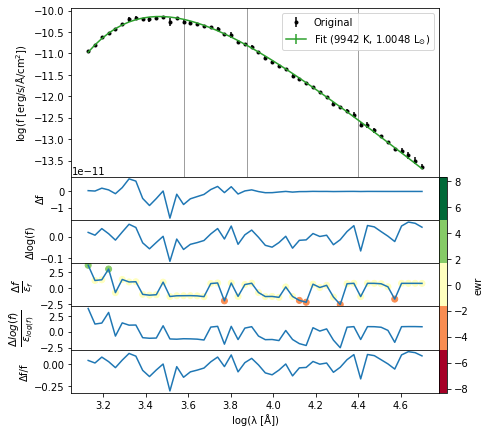

In [3]:
importlib.reload(fc)

starA = fc.Star(10000*u.K, 1*u.solLum, σ=0.1, seed=0)
starA.fit_bb_Single()
starA.plot_fitted('Single')

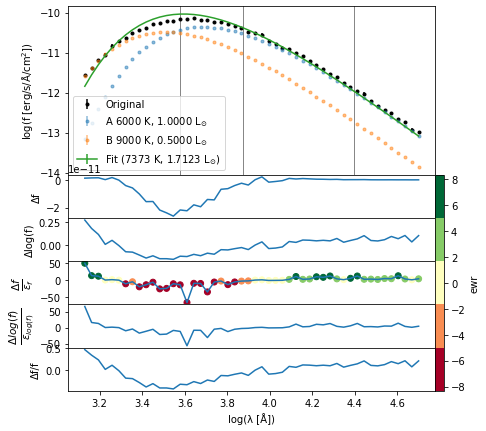

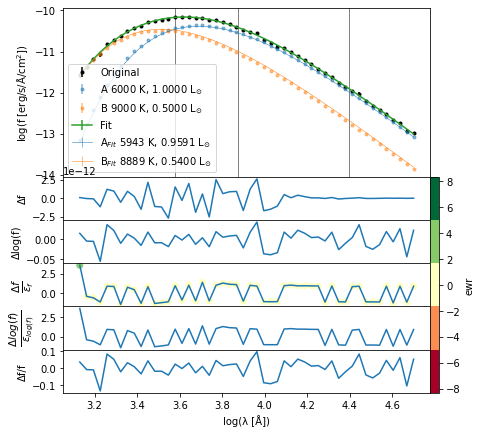

In [4]:
import functions_and_classes as fc
importlib.reload(fc)

binary = fc.Binary( T_A = 6000*u.K,
                    T_B = 9000*u.K,
                    L_A = 1*u.solLum,
                    L_B = 0.5*u.solLum,
                    σ=0.05,
                    seed=2,
                    D=10 * u.pc,
                    x=x_optimistic,
                    name='')
binary.fit_bb_Single()
binary.plot_fitted('Single')
binary.fit_bb_Double(use_priors=True)
binary.plot_fitted('Double')

# Analysing single stars' recovery

9it [00:40,  4.48s/it]


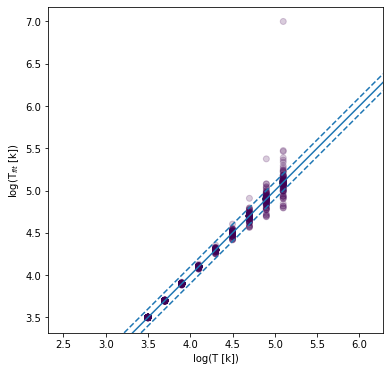

In [5]:
importlib.reload(fc)

logT_A_list = np.linspace(3.5,5.1,9)
logL_A_list = np.full(len(logT_A_list),0)
σ_list = np.logspace(-4,0,9)[:-1]
niter = 50

fit_params = []
for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, σ in enumerate(σ_list[:]):
        for seed in range(niter):
            index = jdx+len(σ_list)*idx
            star = fc.Star(T = 10**_logT *u.K, 
                        L = 1 *u.solLum, 
                        σ=σ,
                        name='T%.2f_sigma%.4f_single'%(_logT,σ),
                        x=x_optimistic,
                        seed=seed)
            star.fit_bb_Single(use_priors=True)

            _fit_params_Single = dict(name=star.name,
                            seed=star.seed,
                            logT=star.logT,
                            logL=star.logL,
                            logT_Single=star.logT_Single,
                            logL_Single=star.logL_Single,
                            sigma = σ)
            fit_params.append(_fit_params_Single)

df_fit_params = pd.DataFrame(fit_params)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(df_fit_params.logT, df_fit_params.logT_Single, c=np.log10(df_fit_params.sigma),
           cmap='viridis_r', alpha=0.2)
ax.axline((4,4),slope=1)
ax.axline((4,4.1),slope=1, ls='--')
ax.axline((4,3.9),slope=1, ls='--')
ax.set(xlabel='log(T [k])', ylabel='log(T$_{fit}$ [k])')
ax.set_aspect('equal', adjustable='datalim')

# Estimating errors

T_in  = 10000.000000
L_in  = 1.000000
T_fit = 9993.906506 ± 34.392923
L_fit = 0.998613 ± 0.006784
  logT= 3.999735 ± 0.001495
  logL= -0.000603 ± 0.002950
Convergence rate:1.00
T_in  = 125892.541179
L_in  = 1.000000
T_fit = 111261.331944 ± 74073.565224
L_fit = 0.702386 ± 1.375385
  logT= 5.046344 ± 0.289137
  logL= -0.153424 ± 0.850418
Convergence rate:0.98


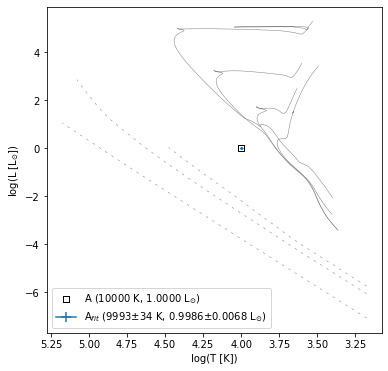

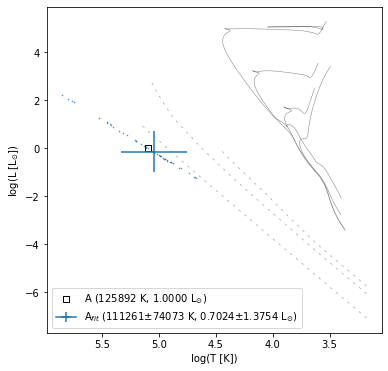

In [11]:
importlib.reload(fc)
import warnings
warnings.filterwarnings("ignore")
df = fc.estimate_errors_Single(10**4*u.K,1*u.solLum,σ=0.01, 
                                x=x_optical_IR, plot=True)
df = fc.estimate_errors_Single(10**5.1*u.K,1*u.solLum,σ=0.1, 
                                x=x_optical_IR, plot=True)

T_in  = [7000.000000]	 [20000.000000]
L_in  = [1.000000]	 [0.003000]
T_fit = [6998.793153 ± 30.399857]	[20436.083262 ± 32299.008270]
L_fit = [0.998338 ± 0.010170]	[0.004096 ± 0.014689]
Convergence rate:1.00


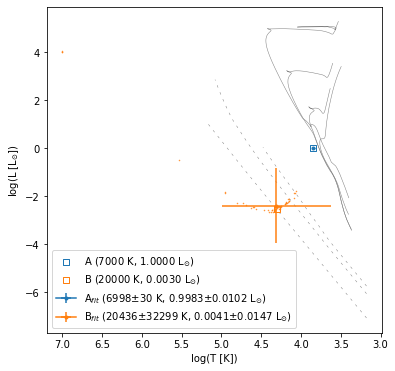

In [10]:
importlib.reload(fc)
df = fc.estimate_errors_Double( T_A = 7000*u.K,
                                L_A = 1*u.solLum,
                                T_B = 20000*u.K,
                                L_B = 0.003*u.solLum,
                                σ=0.05, 
                                x=x_optimistic)

T_in  = [5250.000000]	 [14750.000000]
L_in  = [18.000000]	 [0.093000]
T_fit = [5249.910637 ± 31.553492]	[14786.082183 ± 2724.937796]
L_fit = [17.945793 ± 0.181662]	[0.093032 ± 0.034409]
Convergence rate:1.00


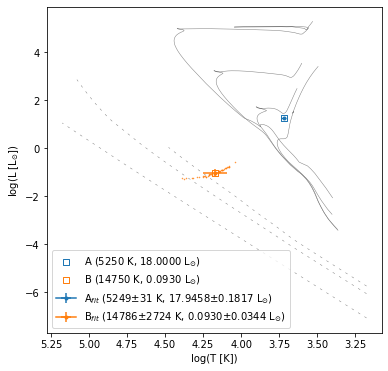

In [31]:
importlib.reload(fc)
'''
Stellar parameters and flux error values are taken from the WOCS2002 star in M67.
'''
df = fc.estimate_errors_Double( T_A = 5250*u.K,
                                L_A = 18*u.solLum,
                                T_B = 14750*u.K,
                                L_B = 0.0930 *u.solLum,
                                σ=[0.05341997, 0.05986721, 0.05341997, 0.02632069, 0.06585393,
                                   0.00377348, 0.06585393, 0.00276771, 0.00400373, 0.06585393,
                                   0.00806181, 0.02026275, 0.01842068, 0.01657861, 0.01934171,
                                   0.01657861, 0.03499929], 
                                x=np.array([3.17055506, 3.18780264, 3.20628604, 3.36236302, 3.63921512,
                                   3.70206419, 3.72967016, 3.7651012 , 3.88195269, 3.90857131,
                                   3.93339412, 4.09166696, 4.22063102, 4.33425264, 4.52538174,
                                   4.6630221 , 5.06298789]),
                                   )#plot_name='plots/public/WOCS2002.jpg')

# Analysing grid of temperature
⚠️ ⚠️ Running these may take >2 hours/cell for rest of the notebook due to the large number of models. ⚠ ⚠

[0.0001     0.00031623 0.001      0.00316228 0.01       0.03162278
 0.1       ] 
 [3.5 3.7 3.9 4.1 4.3 4.5 4.7 4.9 5.1] 
 [0 0 0 0 0 0 0 0 0]


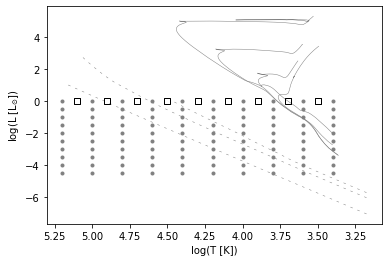

In [24]:
logT_A_list = np.linspace(3.5,5.1,9)
logL_A_list = np.full(len(logT_A_list),0)
σ_list = np.logspace(-4,0,9)[:-2]

logT_B_list = np.linspace(3.4,5.2,10)
logL_B_list = np.linspace(-4.5,0,10)
logT_B_list, logL_B = np.meshgrid(logT_B_list, logL_B_list)
logT_B_list, logL_B_list = logT_B_list.flatten(), logL_B.flatten()

print(σ_list, '\n', logT_A_list, '\n', logL_A_list)
fig, ax = plt.subplots()
fc.Plotter.plot_isochrone_and_wd(ax)
plt.scatter(logT_A_list, logL_A_list, marker='s', edgecolors='k',facecolor='none')
plt.scatter(logT_B_list, logL_B_list, marker='.', color='0.5')

### Grid with optimistic_filters

In [14]:
importlib.reload(fc)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, σ in enumerate(σ_list[:]):
        index = jdx+len(σ_list)*idx
        grid = fc.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    σ=σ,
                    name='T%.2f_sigma%.4f_optimistic'%(_logT,σ),
                    x=x_optimistic)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/optimistic/%s.jpg'%grid.name)

9it [00:29,  3.32s/it]


### Grid with realistic_filters

In [15]:
importlib.reload(fc)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, σ in enumerate(σ_list[:]):
        index = jdx+len(σ_list)*idx
        grid = fc.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    σ=σ,
                    name='T%.2f_sigma%.4f_realistic'%(_logT,σ),
                    x=x_realistic)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/realistic/%s.jpg'%grid.name)


9it [00:20,  2.26s/it]


### Grid with gaia_xp_filters

In [16]:
importlib.reload(fc)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, σ in enumerate(σ_list[:]):
        index = jdx+len(σ_list)*idx
        grid = fc.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    σ=σ,
                    name='T%.2f_sigma%.4f_gaia'%(_logT,σ),
                    x=x_gaia)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/gaia/%s.jpg'%grid.name)

9it [01:37, 10.87s/it]


### Grid with uocs_filters

In [17]:
importlib.reload(fc)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in tqdm(enumerate(logT_A_list[:])):
    for jdx, σ in enumerate(σ_list[:]):
        index = jdx+len(σ_list)*idx
        grid = fc.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=50,
                    σ=σ,
                    name='T%.2f_sigma%.4f_uocs'%(_logT,σ),
                    x=x_uocs)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/uocs/%s.jpg'%grid.name)


9it [00:26,  2.94s/it]


### Grid with optical_IR_filters

In [26]:
importlib.reload(fc)
import warnings
warnings.filterwarnings("ignore")

for idx, _logT in (enumerate(logT_A_list[:])):
    for jdx, σ in enumerate(σ_list[:]):
        index = jdx+len(σ_list)*idx
        grid = fc.Grid(T_A = 10**_logT *u.K, 
                    L_A = 1 *u.solLum, 
                    logT_B_list = logT_B_list, 
                    logL_B_list = logL_B_list, 
                    niter=10,
                    σ=σ,
                    name='T%.2f_sigma%.4f_optIR'%(_logT,σ),
                    x=x_optical_IR)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/optIR/%s.jpg'%grid.name)


# Analysing unresolved binaries using Gaia XP spectra

[0.0001     0.00031623 0.001      0.00316228 0.01       0.03162278] 
 [0.9, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0] 
 [3.73130222 3.75960804 3.8041     3.8655     3.9765     4.04995976
 4.1042     4.18303567 4.24364719 4.2912     4.35817123 4.40974122] 
 [-0.3318039  -0.11695627  0.267       0.718       1.24        1.62019299
  1.926       2.39660155  2.74830951  3.025       3.45681497  3.76927827]


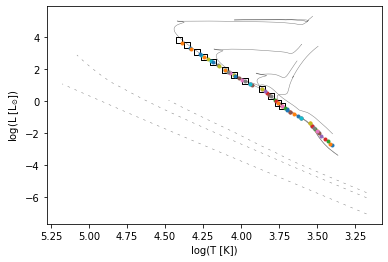

In [19]:
zams = pd.read_csv(fc.DIR_MODELS+'master_ZAMS.csv')
zams = zams[zams.MH==0].sort_values(by='Mass')

mass_list = [0.9,1.0,1.2,1.5,2.0,2.5,3.0,4.0,5.0,6.0,8.0,10.0]
logT_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logTe)
logL_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logL)
σ_list = np.logspace(-4,-1,7)[:-1]

print(σ_list, '\n', mass_list, '\n', logT_A_list, '\n', logL_A_list)

fig, ax = plt.subplots()
fc.Plotter.plot_isochrone_and_wd(ax)
plt.scatter(logT_A_list, logL_A_list, marker='s', edgecolors='k',facecolor='none')
for mass in mass_list:
    secondary_mass_list = mass * np.array([0.1,0.3,0.5,0.7,0.9])
    logT_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logTe)
    logL_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logL)
    plt.scatter(logT_B_list, logL_B_list, marker='.')

In [20]:
importlib.reload(fc)

for idx, mass in tqdm(enumerate(mass_list[:])):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]

    secondary_mass_list = mass * np.array([0.1,0.3,0.5,0.7,0.9])
    logT_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logTe)
    logL_B_list = np.interp(np.log10(secondary_mass_list), np.log10(zams.Mass), zams.logL)
    
    for jdx, σ in enumerate(σ_list[:]):
        index = jdx+len(σ_list)*idx
        grid = fc.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    σ=σ,
                    name='M%.2f_sigma%.4f_gaia'%(mass, σ),
                    logT_B_list=logT_B_list,
                    logL_B_list=logL_B_list,
                    x=x_gaia)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/unresolved/%s.jpg'%grid.name)

12it [00:06,  1.76it/s]


# Analysing UOCS type hotter companions

[0.001      0.00316228 0.01       0.03162278 0.1       ] 
 [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0] 
 [3.6961     3.75960804 3.8041     3.8421     3.8922     3.93910271
 3.9765     4.04995976 4.1042    ] 
 [-0.569      -0.11695627  0.267       0.583       0.842       1.05397301
  1.24        1.62019299  1.926     ]


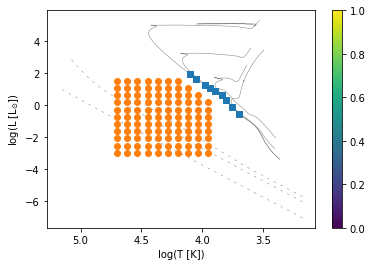

In [21]:
zams = pd.read_csv(fc.DIR_MODELS+'master_ZAMS.csv')
zams = zams[zams.MH==0].sort_values(by='Mass')

mass_list = [0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.5,3.0]
logT_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logTe)
logL_A_list = np.interp(np.log10(mass_list), np.log10(zams.Mass), zams.logL)
σ_list = np.logspace(-3,-1,5)[:]

print(σ_list, '\n', mass_list, '\n', logT_A_list, '\n', logL_A_list)

logT_B_list = np.linspace(4.7,3.95,10)
logL_B_list = np.linspace(-3,1.5,11)
logT_B_list, logL_B_list = np.meshgrid(logT_B_list, logL_B_list)
i = np.indices(logT_B_list.shape)
_filter = (i[0]+i[1]<17)
_filter = _filter.flatten()
logT_B_list = logT_B_list.flatten()[_filter.flatten()]
logL_B_list = logL_B_list.flatten()[_filter.flatten()]

fig, ax = plt.subplots()
fc.Plotter.plot_isochrone_and_wd(ax=ax)
ax.scatter(logT_A_list,logL_A_list, marker='s')
p0 = ax.scatter(logT_B_list,logL_B_list)
plt.colorbar(p0)

### Hotter companions with uocs_filters

In [22]:
importlib.reload(fc)
import warnings
warnings.filterwarnings("ignore")

for idx, mass in tqdm(enumerate(mass_list[:])):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]   
    _filter =  (logL_B_list <=logL_A_list[idx])
    for jdx, σ in enumerate(σ_list[:]):
        index = jdx+len(σ_list)*idx
        grid = fc.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    σ=σ,
                    name='M%.2f_sigma%.4f_uocs'%(mass,σ),
                    logT_B_list=logT_B_list[_filter],
                    logL_B_list=logL_B_list[_filter],
                    x=x_uocs)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/hotter_companion/%s.jpg'%grid.name)


9it [00:17,  1.95s/it]


### Hotter companions with optical_IR_filters

In [23]:
importlib.reload(fc)
import warnings
warnings.filterwarnings("ignore")

for idx, mass in tqdm(enumerate(mass_list[:])):
    T_A = 10**logT_A_list[idx]
    L_A = 10**logL_A_list[idx]   
    _filter =  (logL_B_list <=logL_A_list[idx])
    for jdx, σ in enumerate(σ_list[:]):
        index = jdx+len(σ_list)*idx
        grid = fc.Grid(T_A = T_A*u.K, 
                    L_A = L_A*u.solLum, 
                    niter=50,
                    σ=σ,
                    name='M%.2f_sigma%.4f_optIR'%(mass,σ),
                    logT_B_list=logT_B_list[_filter],
                    logL_B_list=logL_B_list[_filter],
                    x=x_optical_IR)
        grid.calculate_params(refit=False)
        grid.plot(plot_name='plots/HRDs/hotter_companion/%s.jpg'%grid.name)


9it [00:19,  2.12s/it]
